# Import libarys

In [2]:
# General
import numpy as np
import pandas as pd
from datetime import datetime, date

# Plot libarys
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

# Import and save
import pickle

# Prophet
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Further
import warnings
import itertools

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


# Global settings

In [3]:
warnings.filterwarnings('ignore')
RSEED = 1

plt.rcParams['figure.figsize'] = [14, 8]
sns.set_style('whitegrid')#("darkgrid") 
sns.set_palette('cubehelix')

# Load data

In [6]:
with open('data/orig_ts2_new.csv', 'rb') as f:
    df_one, df_two, df_three = pickle.load(f)

In [7]:
df_one.head(2)

,amount_sold,amount_delivered,timestamp,date,year,month,week,day,dayofyear,weekday
0,9.0,20,2012-01-16,2012-01-16,2012,1,3,16,16,0
1,14.0,20,2012-01-17,2012-01-17,2012,1,3,17,17,1


In [8]:
df_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 993 entries, 0 to 5389
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   amount_sold       993 non-null    float64       
 1   amount_delivered  993 non-null    int64         
 2   timestamp         993 non-null    datetime64[ns]
 3   date              993 non-null    object        
 4   year              993 non-null    int64         
 5   month             993 non-null    int64         
 6   week              993 non-null    int64         
 7   day               993 non-null    int64         
 8   dayofyear         993 non-null    int64         
 9   weekday           993 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 85.3+ KB


Since Propphet expects the data in a certain form, the features must be renamed to 'y' and the time column to 'ds':

In [15]:
df_one = df_one.rename(columns={'timestamp':'ds','amount_sold':'y'})
df_one.head()

,y,amount_delivered,ds,date,year,month,week,day,dayofyear,weekday
0,9.0,20,2012-01-16,2012-01-16,2012,1,3,16,16,0
1,14.0,20,2012-01-17,2012-01-17,2012,1,3,17,17,1
2,29.0,30,2012-01-18,2012-01-18,2012,1,3,18,18,2
3,13.0,15,2012-01-19,2012-01-19,2012,1,3,19,19,3
4,14.0,25,2012-01-20,2012-01-20,2012,1,3,20,20,4


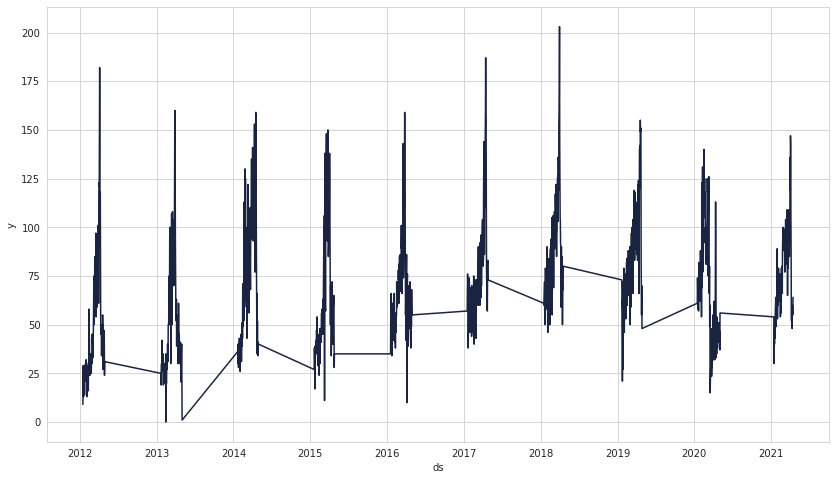

In [17]:
sns.lineplot(data=df_one, y='y', x='ds')
plt.show()

# Spliting the data
In train and test

In [40]:
train = df_one.query('year<2021').sort_values(by='date')
test = df_one.query('year==2021').sort_values(by='date')
print(train[['y','ds']].tail())
print(train.shape)
print('------------')
print(test[['y','ds']].head())
print(test.shape)

        y         ds
977  42.0 2020-04-28
978  47.0 2020-04-29
979  45.0 2020-04-30
613  37.0 2020-05-01
614  56.0 2020-05-02
(901, 10)
------------
        y         ds
373  54.0 2021-01-13
376  30.0 2021-01-14
379  47.0 2021-01-15
496  40.0 2021-01-16
499  51.0 2021-01-17
(92, 10)


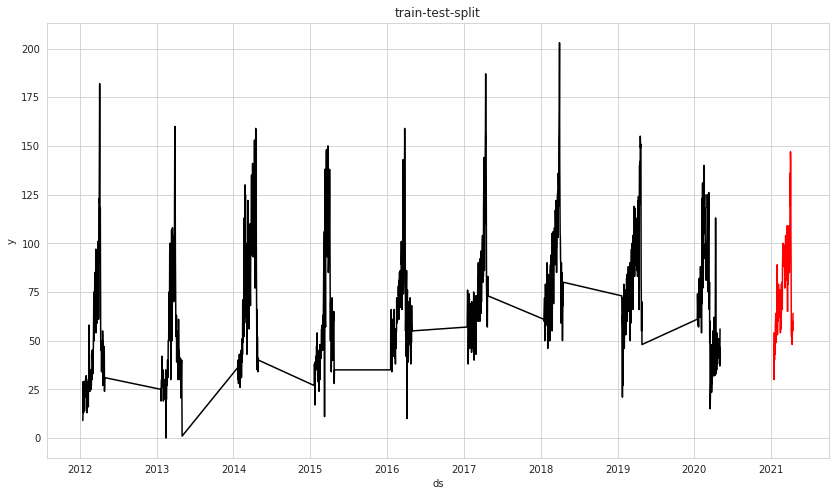

In [29]:
sns.lineplot(data=train, y='y', x='ds', color='black')
sns.lineplot(data=test, y='y', x='ds', color='red')
plt.title('train-test-split');

# Model without additional seasonalities
and with only standard settings

             ds
5377 2021-04-10
5380 2021-04-11
5383 2021-04-12
5386 2021-04-13
5389 2021-04-14
           ds       yhat  yhat_lower  yhat_upper
87 2021-04-10  75.456220   26.384617  126.291330
88 2021-04-11  81.919831   33.924428  132.186941
89 2021-04-12  82.478749   30.235056  134.353718
90 2021-04-13  80.435203   30.712430  132.097945
91 2021-04-14  83.415020   35.077348  135.002232
mse: 515.4985436680951; rmse: 22.704593008202


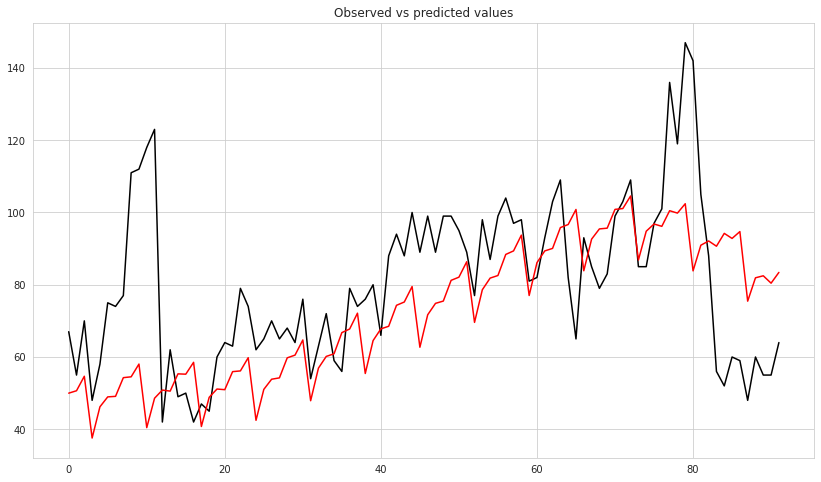

In [44]:
# Initialize  model
m1 = Prophet(interval_width=0.95, weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=True)

# Fit model
m1.fit(train)

# Define prediction period
#future_dates1 = m1.make_future_dataframe(periods=110, freq='D', include_history=True)
future_dates1 = pd.DataFrame(test.ds)
print(future_dates1.tail())

# Make forecst
forecast1 = m1.predict(future_dates1)
print(forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


y_true1 = df_one.y[-len(test):].values
y_pred1 = forecast1.yhat.values

mse = mean_squared_error(y_true1, y_pred1)
rmse = mean_squared_error(y_true1, y_pred1, squared=False)
print(f'mse: {mse}; rmse: {rmse}')

plt.plot(y_true1, color='black', label='observed ')
plt.plot(y_pred1, color='red', label='predicted')
plt.title('Observed vs predicted values')
plt.savefig('images/prophet_without_small.png');

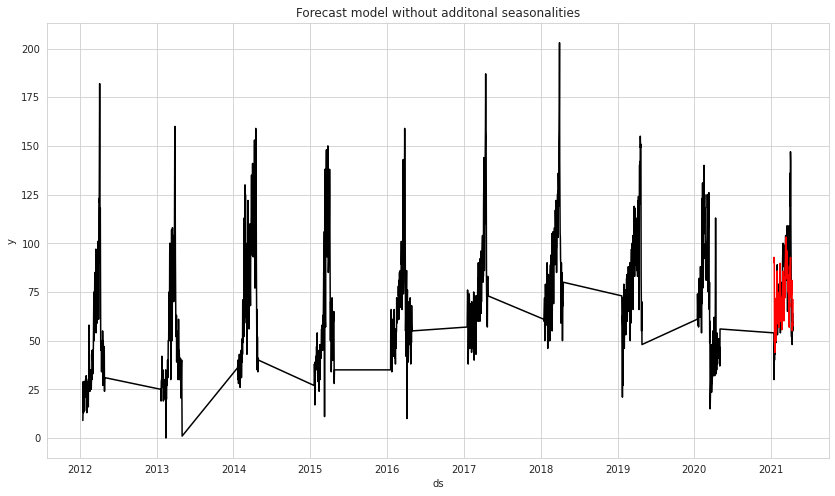

In [68]:
sns.lineplot(data=df_one, y='y', x='ds', color='black')
sns.lineplot(data=forecast2, y='yhat', x='ds', color='red')
plt.title('Forecast model without additonal seasonalities')
plt.savefig('images/prophet_without.png');

# Model with additional seasonalities
+ and holidays 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
             ds
5377 2021-04-10
5380 2021-04-11
5383 2021-04-12
5386 2021-04-13
5389 2021-04-14
           ds       yhat  yhat_lower  yhat_upper
87 2021-04-10  55.083829   -0.863589  108.578698
88 2021-04-11  59.189886    0.900850  114.642181
89 2021-04-12  57.420873    2.879919  113.005443
90 2021-04-13  59.042381    0.583526  116.840012
91 2021-04-14  71.114963   13.734339  127.078333
mse: 536.7992395465836; rmse: 23.168928321063614


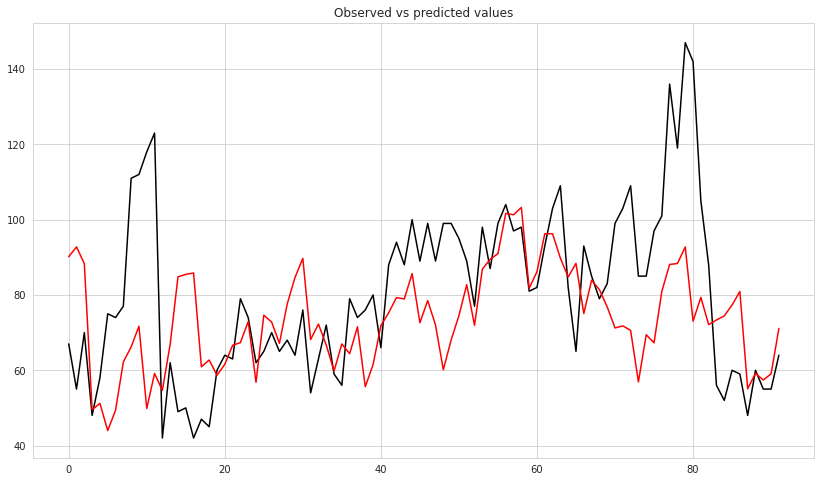

In [67]:
m2 = Prophet(interval_width=0.95, weekly_seasonality=False, yearly_seasonality=False)#, 

# Add all found seasonalities
m2.add_seasonality(name='year', period=365.25, fourier_order=10)
m2.add_seasonality(name='year', period=100.11, fourier_order=10)
m2.add_seasonality(name='seven', period=77, fourier_order=10)
m2.add_seasonality(name='weekly', period=53, fourier_order=10)
m2.add_seasonality(name='fourty', period=43.5, fourier_order=10)
m2.add_seasonality(name='week', period=18, fourier_order=10)
m2.add_seasonality(name='monthly', period=12, fourier_order=10)
m2.add_seasonality(name='day', period=7, fourier_order=10)
m2.add_seasonality(name='month', period=5, fourier_order=10)

# Add Austria  holidays
m2.add_country_holidays(country_name='AT')

future_dates2 = pd.DataFrame(test.ds)
print(future_dates2.tail())

m2.fit(train)

#forecast = my_model.predict(future_dates)
forecast2 = m2.predict(future_dates2)
print(forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


y_true2 = df_one.y[-len(test):].values
y_pred2 = forecast2.yhat.values

mse = mean_squared_error(y_true2, y_pred2)
rmse = mean_squared_error(y_true2, y_pred2, squared=False)
print(f'mse: {mse}; rmse: {rmse}')

plt.plot(y_true2, color='black', label='observed ')
plt.plot(y_pred2, color='red', label='predicted')
plt.title('Observed vs predicted values')
plt.savefig('images/prophet_with_S_small.png');

In [ ]:
sns.lineplot(data=df_one, y='y', x='ds', color='black')
sns.lineplot(data=forecast2, y='yhat', x='ds', color='red')
plt.title('Forecast model with additonal seasonalities')
plt.savefig('images/prophet_with_S.png');

# Model with additional seasonalities
+ holidays 
+ 'is_season' -> Divides the year into selling season and no selling season

=> the 'is_season' rather leads to a worsening

In [56]:
def is_season(ds):
    date = pd.to_datetime(ds)
    return (date.month < 5)

train['on_season'] = train.ds.apply(is_season)
train['off_season'] = ~train.ds.apply(is_season)

test['on_season'] = test.ds.apply(is_season)
test['off_season'] = ~test.ds.apply(is_season)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
           ds       yhat  yhat_lower  yhat_upper
87 2021-04-10  55.083829   -0.604148  110.257246
88 2021-04-11  59.189886    1.523944  118.633987
89 2021-04-12  57.420873    2.334063  115.128039
90 2021-04-13  59.042381    1.405112  113.507183
91 2021-04-14  71.114963   13.255891  128.229157
mse: 536.7992395465836; rmse: 23.168928321063614


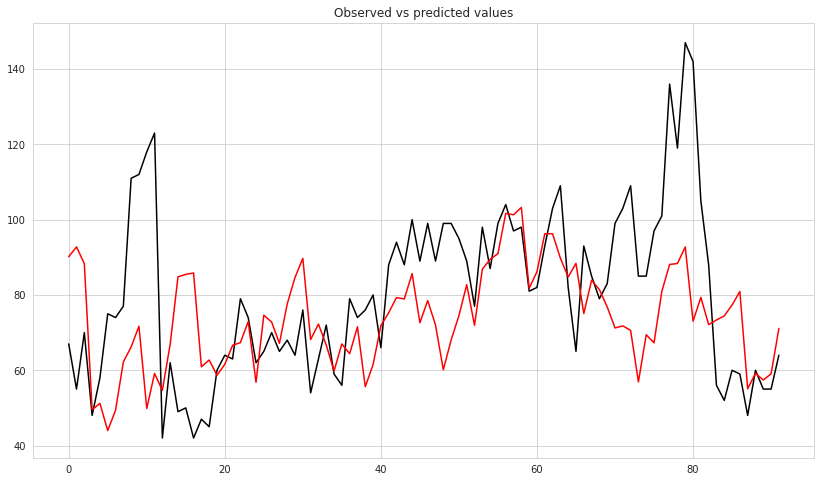

In [66]:
m2 = Prophet(interval_width=0.95, weekly_seasonality=False, yearly_seasonality=False)#, 

# Add all found seasonalities
m2.add_seasonality(name='year', period=365.25, fourier_order=10)
m2.add_seasonality(name='year', period=100.11, fourier_order=10)
m2.add_seasonality(name='seven', period=77, fourier_order=10)
m2.add_seasonality(name='weekly', period=53, fourier_order=10)
m2.add_seasonality(name='fourty', period=43.5, fourier_order=10)
m2.add_seasonality(name='week', period=18, fourier_order=10)
m2.add_seasonality(name='monthly', period=12, fourier_order=10)
m2.add_seasonality(name='day', period=7, fourier_order=10)
m2.add_seasonality(name='month', period=5, fourier_order=10)

# Add Austria  holidays
m3.add_country_holidays(country_name='AT')


m3.add_seasonality(name='yearly_on_season', period=365, fourier_order=10, condition_name='on_season')
m3.add_seasonality(name='yearly_off_season', period=365, fourier_order=10, condition_name='off_season')

future_dates3 = pd.DataFrame(test.ds)
print(future_dates3.tail())

future_dates3['on_season'] = future_dates3['ds'].apply(is_season)
future_dates3['off_season'] = ~future_dates3['ds'].apply(is_season)

m3.fit(train)


#forecast = my_model.predict(future_dates)
forecast3 = m3.predict(future_dates2)
print(forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


y_true3 = df_one.y[-len(test):].values
y_pred3 = forecast3.yhat.values

mse = mean_squared_error(y_true3, y_pred3)
rmse = mean_squared_error(y_true3, y_pred3, squared=False)
print(f'mse: {mse}; rmse: {rmse}')

plt.plot(y_true3, color='black', label='observed ')
plt.plot(y_pred3, color='red', label='predicted')
plt.title('Observed vs predicted values')
plt.savefig('images/prophet_with_all_small.png');

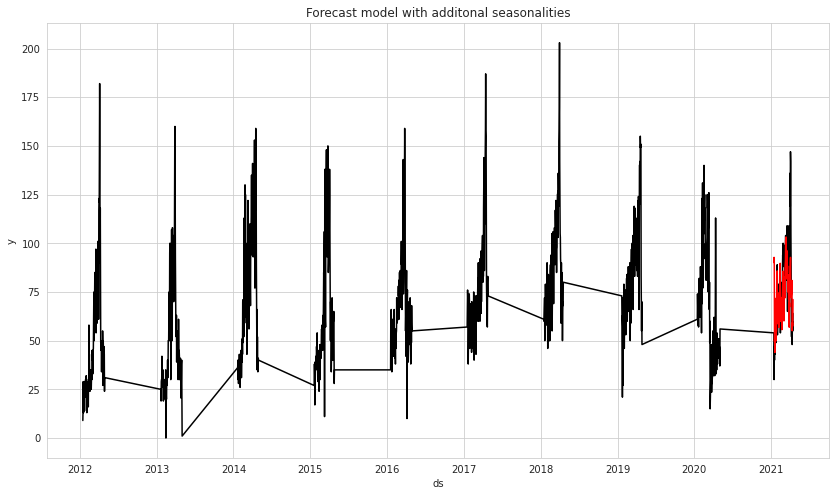

In [69]:
sns.lineplot(data=df_one, y='y', x='ds', color='black')
sns.lineplot(data=forecast2, y='yhat', x='ds', color='red')
plt.title('Forecast model with additonal seasonalities')
plt.savefig('images/prophet_with_all.png');

In [49]:
forecast2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          92 non-null     datetime64[ns]
 1   trend                       92 non-null     float64       
 2   yhat_lower                  92 non-null     float64       
 3   yhat_upper                  92 non-null     float64       
 4   trend_lower                 92 non-null     float64       
 5   trend_upper                 92 non-null     float64       
 6   Allerheiligen               92 non-null     float64       
 7   Allerheiligen_lower         92 non-null     float64       
 8   Allerheiligen_upper         92 non-null     float64       
 9   Christi Himmelfahrt         92 non-null     float64       
 10  Christi Himmelfahrt_lower   92 non-null     float64       
 11  Christi Himmelfahrt_upper   92 non-null     float64       
 

Although at this point it is unfortunately not possible to beat the standard settings of the prophet, it could still be shown that it is possible to use this model for multiple self-defined seasonalities.

The fact that the model did not improve is probably due to the fact that the parameters would still have to be optimised, e.g. by a grid search. Furthermore, it could be helpful to include not only the forier.order, but also the priorscales.

 + Fourier.order : Increasing it allows the model for fitting the seasonal patterns that change more quickly. 
 + Seasonality.priorscale : It is the control for the amount of regularization on the model seasonality. Regularization is important to avoid overfitting. 